In [1]:
from functions_trained_reservoir import *

from random import randint

from IPython.display import clear_output

from reservoirpy.nodes import Reservoir,FORCE,Ridge
from reservoirpy.mat_gen import Initializer,_scale_spectral_radius
from reservoirpy.observables import spectral_radius
from tqdm import tqdm

from ReccurentNetwork import *

import numpy as np
import copy
from numpy.linalg import eig

import spicy as sp
import matplotlib.pyplot as plt

In [2]:
#Code importé de ReservoirPy
def _rls(P, x, e):
    """Recursive Least Squares learning rule."""
    k = np.dot(P, x)
    xPx = np.dot(x.T, k)
    c = float(1.0 / (1.0 + xPx))
    P = P - c * np.outer(k, k)
    dw = -c * np.outer(e, k)

    return dw, P

# Réseaux de neurones

On cherche ici dans un premier temps à reprdoduire les figures les plus simples de l'article. 

Les mesures de l'article sont effectuées sur 2 réservoirs : 

  - le premier est dit entrainé : on va alors entrainer le réservoir et la sortie
  - le second lui est dit non entrainé : on entraine seulement la sortie
    

Ce premier script s'intéresse donc à la reproduction de l'entrainement des figures 3, 4 et 5 ainsi qu'aux résultas obtenus sur un réservoir entrainé.


## Expériences

Deux expériences quasiment similaires sont proposés pour un réservoir totalement entrainé. La seule différence entre ces dernières sont le nombre de neurones utilisés dans le réservoir : 

   - Soit N = 2100 pour des résultats robustes entre toutes les données pour un sujet
   - Soit N = 4000 pour des résultats robustes entre tous les sujets (5 au maximum)
    
Nous traiterons le premier  cas dans ce papier.

##### Méthode d'entrainement

Pour ce qui est de l'entrainement du réservoir nous allons procéder comme ceci : nous séparons notre entrée en deux parties : l'époque sensorielle et l'époque motricielle. 

###### Epoque sensorielle : 

Pour un sujet donné et parmit toutes les entrées différentes, pour chaque chiffre on selectionne une entrée moyenne. Cette entrée est injectée dans le réservoir sans bruit et sans target, on obtient alors une trajectoire resultante de taille (Timesteps x Nombre de neurones) pour chaque chiffre. Ces 10 trajectoires sont appelées les "innate trajectories" et seront les targets pour toutes les autres entrées durant l'entrainement du l'époque sensorielle en faisant bien attention à  ce que la dimension d'entrée des nouvelles entrées soit cohérente avec celle de l'innate trajectorie, on procédera alors pas une déformation linéaire de l'innate trajectory. De plus, du bruit sera présent durant l'entrainement.

###### Epoque motrice

Pour ceux qui est de l'époque motrice : On met dans le réservoir un cocléogramme moyen pour un chiffre donné, et la target de l'époque motrice est l'activité autonome générée par le réservoir sur une durée comprenant la transition époque sensorielle/motrice et l'époque motrice  (pas du tout sur)

##### Entrainement

On concatene maintenant l'innate trajectory de l'époque sensorielle et de l'époque motrice pour obtenir nos targets finales.

À noter, que chaque entrainement et test commence à -100ms avec le réseau initialisé selon une loi uniform de -1 à 1.
--> On laisse tourner le réservoir pendant 100ms à blanc ouis on met les entrées ????


###### Test
Les test effectués dans ce script seront fait sur le sujet 1

Données générales 

In [3]:
data = extract_data() #Données d'entrée
transcription = extract_target() #Données d'arrivée 

#Les données suivantes sont utilisés dans les fonctions mais pas dans le script ! 

freq_ent = 6*10**3  #fréquence d'entrée
T_ent = 1/freq_ent  #période d'entrée

freq_out = 10**3 #fréquence de sortie 
T_out = 1/freq_out #période de sortie

ampl_int = 5 #Amplitude d'entrée

Données du réservoir

In [4]:
N = 2100//10 #Nombre de neurones dans le réservoir
M = 12 #Nombres d'entrées
No = 3 #Nombres de sorties
tau = 25*10e-3
dt = 1e-3
lr = dt/tau
sr = 1.6 #spectral radius --> gain ?
g = 1.6 #le gain du réseau ?                             #je comprends pas trop cette donnée. 
pc = 0.2 # connectivité entre les neurones (pc dans l'article)
SD = g/np.sqrt(pc*N)
mu = 0
I0 = 0.05 

Wo = normal(No,N,loc=mu,scale = 1/np.sqrt(N))    #Matrice de sortie : Non utilisée


Création de la matrice du réservoir : avec pas d'autapse
Puis bricolage pour réxupérer le rayon spectral voulu

In [5]:
W_r.init = Initializer(W_r)

W = _scale_spectral_radius(W_r.init, [N,N], sr)
W = W.toarray()

Création de la matrice d'entrée : chaque entrée k est projetée sur le neurone $(k-1)\frac{N}{M} + 1$ jusqu'au neurone $k\frac{N}{M}$ selon une loi normale 

In [6]:
Win = W_in(N,M)

# Epoque sensorielle 

Récupération des cocleograms avec une taille moyenne pour chaque chiffre 

In [7]:
median_entrance_cocleogram = median_cocleogram(data,sujet=[1])

Création d'un réservoir :

In [8]:
reservoir_innate = Reservoir(W=W,Win=Win)

Détermination des trajectoires inées  

In [9]:
innate_trajectories_sensor = []
for i in range(len(median_entrance_cocleogram)):
    
    #Récupération du cocleogram moyen
    X =  median_entrance_cocleogram[i]
    
    #Récupération des trajectoires innées de l'époque sensorielle 
    initial_trajectory = reservoir_innate.run(X)
    
    #Ensuite on les trie
    innate_trajectories_sensor.append(initial_trajectory)

clear_output()

# Epoque Motrice

On met dans le réservoir un cocléogramme moyen pour un chiffre donné, et la target de l'époque motrice est l'activité autonome générée par le réservoir sur une durée comprenant la transition époque sensorielle/motrice et l'époque motrice  

In [10]:
innate_trajectories_motor = []
for i in range(len(median_entrance_cocleogram)):
    
    #Récupération du cocléogramme moyen
    X_input = median_entrance_cocleogram[i]
    
    #Récupération du temps entre la fin de l'époque sensorielle et la fin de l'époque motrice
    t = duree_transition_motor(i)
    
    #Récupération du temps de l'époque sensorielle
    t_cocleo, _ = np.shape(median_entrance_cocleogram[i])
    
    #Différence des deux valeurs : 
    diff = t - t_cocleo
    
    #Ensuite on modifie l'entrée pour que cela corresponde au temps de l'époque motrice
    if diff >= 0:
        X_input = np.concatenate((X_input,np.zeros((diff,12))),axis = 0)
    else:
        X_input = X_input[:t,:]
        
    #Maintenant que nos valeurs à mettre dans le réservoir sont prêtes, on fait tourner le réservoir
    innate_trajectories_motor.append(reservoir_innate.run(X_input))
    
clear_output()

# Entrainement du réservoir 

Maintenant que les targets pour les différentes époques sont prêtes, il va falloir concaténer le tout. Donc pour chaque entrée, on va d'abord déformer linéairement la trajectoire innée de l'époque sensorielle, puis, on va ajouter la target de l'époque motrice en concaténant les matrices

In [11]:
X_input = []
X_target = []
for indS in [1] : 
    for indU in range(1,4):
        for indD in range(10):
            #Ajout de l'input
            X_input.append(np.transpose(formatage_cocleogram(indS, indU, indD,data)))
            
            #Récupération de la target de l'époque sensorielle
            target_sensor = linear_warping(indS,indU,indD,data,innate_trajectories_sensor[indD])   
            
            #Récupération de la target de l'époque motrice et de la transition
            target_motor_transition = innate_trajectories_motor[indD]

            #Concaténation et ajout dans la target
            X_target.append(np.concatenate((target_sensor,target_motor_transition),axis=0))

## Test de RLS sans utiliser le noeud de reservoirpy

Définition des valeurs qui vont me servir. Et, dans l'article, seulement 90% des connexions sont modifiées, je définis alors les indices qui ne seront pas modifés

In [12]:
#Matrice de gain
P = np.identity(N)

#Etat initial du réservoir
x= np.random.uniform(-1,1,(N,1))

#Matrice du réservoir
W_rls = copy.deepcopy(W)

#Nombre de connexion qui ne devront pas changer
nbr = int(N*0.1)

#Les indices des connexions qui ne changeront pas 
indice_rows = [randint(0,N-1) for i in range(nbr)]
indice_cols = [randint(0,N-1) for i in range(nbr)]

On laisse d'abord tourner le réservoir pendant 100ms (avec une période de 1ms), et on récupère l'état des neurones pour l'injecter dans un réservoir et commencer notre entrainement.

In [13]:
for xi,xt in tqdm(zip(X_input,X_target)):                
    
    #On laisse d'abord le réseau tourner pendant 100 ms sans entrée
    for i in range(100):
        x_1 = (1-lr)*x + lr*np.tanh(np.dot(W_rls,x)) 
        x = x_1
    error = []
    
    c = 0
    
    #Ensuite on commence la phase d'entrainement du réseau
    for t in tqdm(range(len(xi))):                                           
        
        #Création du bruit
        I_noise = np.random.normal(0,1,size =np.shape(x)) + SD*I0                     
        
        #Calcul de l'état x(t+1)
        x1 = (1-lr)*x + lr*np.tanh(np.dot(Win,np.expand_dims(xi[t], axis=1))+np.dot(W_rls,x)) +I_noise  
        
        #Calcul de l'erreur
        e = np.expand_dims(xt[t],axis=1) - x1                     
        
        #Calcul de la variation de W ainsi que de la matrice de gain 
        dW_rls,P = _rls(P, x1, e)                                   
        
        #On enlève 10% des variations de la matrice W 
        for r,c in zip(indice_rows,indice_cols):
            dW_rls[r,c] = 0
        
        #Modification de la matrice W 
        W_rls -= dW_rls
        
        #l'état suivant devant l'état actuel
        x = x1
        
        #ajout de l'erreur pour ensuite en faire une moyenne 
        error.append(e)
    
    clear_output()
    
    c += 1
    
    print("moyenne des erreurs sur l'entrainement {} : {} ".format(c,moyenne(e)))
        


30it [00:29,  1.02it/s]

moyenne des erreurs sur l'entrainement 162 : [-3.66553074] 


Affichage des valeurs propres : dans l'article, après l'entrainement, ces valeurs propres diminuent alors que moi elles augmentent.

C:\Users\smoot\Desktop\Stage Mnemosyne\functions_trained_reservoir.py:469: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


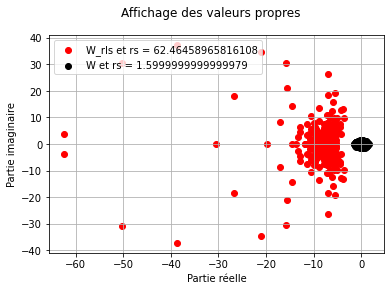

In [14]:
eigein_value(W_rls,W,"W_rls","W")

Test :

In [15]:
X_test = X_input[1]
X_target_test = X_target[1]
x = np.random.normal(0,1,(N,1))

X_pred = [] #représente aussi l'état des neurones 

for t in tqdm(range(len(X_test))):
    x1 = (1-lr)*x + lr*np.tanh(np.dot(Win,np.expand_dims(X_test[t], axis=1))+np.dot(W,x))
    
    #???????????????????????????????????
    if len(X_pred) == 0:
        X_pred = np.transpose(x1)
    else : 
        X_pred = np.append(X_pred,np.transpose(x1),axis = 0)
    
    x = x1

    

100%|██████████████████████████████████████████████████████████████████████████████| 970/970 [00:00<00:00, 2753.95it/s]


Affichage des résultats (pas représentatif)

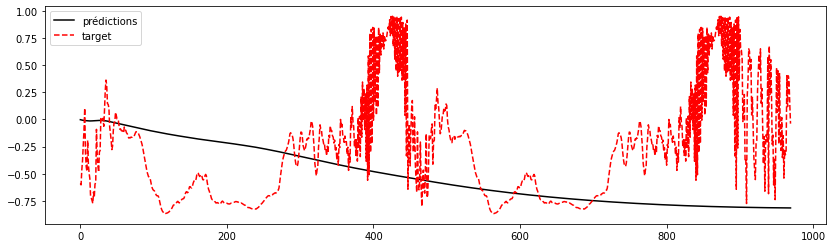

In [16]:
fig,ax = plt.subplots(figsize = (14,4))
ax.plot(X_pred[:,:1],"k",label="prédictions")
ax.plot(X_target_test[:,:1],"--r",label = 'target')
ax.legend()

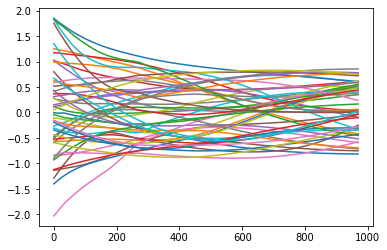

In [17]:
plt.plot(X_pred[:,:50])
clear_output()

Affichage de la matrice :

-0.2358681323159661


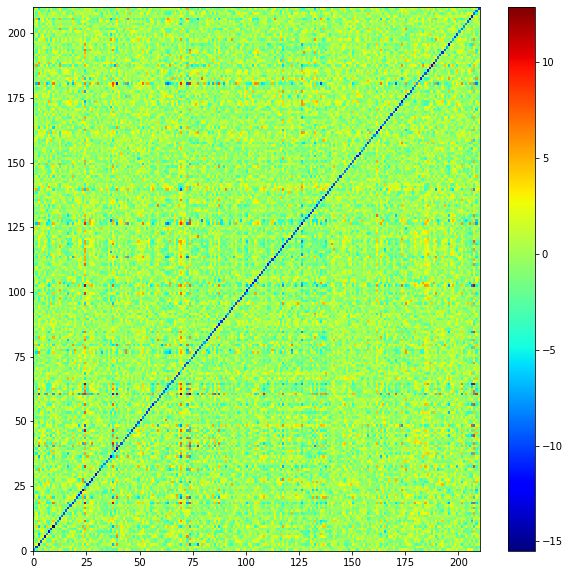

In [18]:
fig, ax0 = plt.subplots(figsize=(10,10))

im = ax0.pcolormesh(W_rls, cmap="jet",)
fig.colorbar(im, ax=ax0)
print(np.mean(W_rls))

## Test de RLS en utilisant le noeud de reservoirpy

In [19]:
W_reservoir = copy.deepcopy(W)
reservoir = Reservoir(W=W_reservoir,Win=Win,rc_noise = SD*I0)

Définition des valeurs qui vont me servir. Et, dans l'article, seulement 90% des connexions sont modifiées, je définis alors les indices qui ne seront pas modifés

In [20]:
#Matrice de gain
P = np.identity(N)

#Matrice vide
blanc = np.zeros((100,12))


#Nombre de connexion qui ne devront pas changer
nbr = int(N*0.1)

#Les indices des connexions qui ne changeront pas 
indice_rows = [randint(0,N-1) for i in range(nbr)]
indice_cols = [randint(0,N-1) for i in range(nbr)]

On laisse d'abord tourner le réservoir pendant 100ms (avec une période de 1ms), et on récupère l'état des neurones pour l'injecter dans un réservoir et commencer notre entrainement.

In [21]:
for xi,xt in tqdm(zip(X_input,X_target)):

    #On laisse d'abord le réservoir tourner à vide pendant 100 ms
    Test = reservoir.run(blanc)
    
    #Ensuite on l'entraine
    
    #On calcul la sortie du réservoir pour une entrée
    x1 = reservoir.run(xi)
    
    #On calcul l'erreur 
    e = x1-xt
    
    #Et pour chaque pas de temps, on va modifier la matrice 
    for t in range(len(x1)):
        
        #Calcul de la variation de W et de la matrice de gain
        dW, P = _rls(P,x1[t],e[t])
        
        #On enlève 10% des changements
        for r,c in zip(indice_rows,indice_cols):
            dW[r,c] = 0 
        
        #On modifie W
        W_reservoir -= dW
        
    #On injecte W dans le réservoir pour les nouveux calculs
    reservoir.set_param("W",W_reservoir)

    clear_output()
    #print(moyenne(e))
    

30it [00:26,  1.14it/s]


In [22]:
N*0.1

21.0

Affichage des valeurs propores :

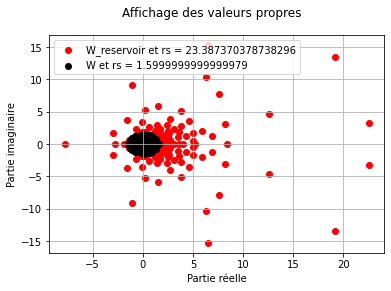

In [23]:
eigein_value(W_reservoir,W,"W_reservoir","W")

Test du réservoir 

In [24]:
X_test = X_input[1]
X_target_test = X_target[1]

X_pred = reservoir.run(X_test)

Running Reservoir-1: 100%|█████████████████████████████████████████████████████████| 970/970 [00:00<00:00, 5464.12it/s]


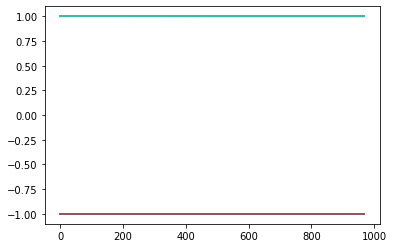

In [25]:
plt.plot(X_pred[:,:100])
clear_output()

Le réservoir est totalement saturé 

Affichage des résultats (pas représentatif), on voit que le réseau sature.

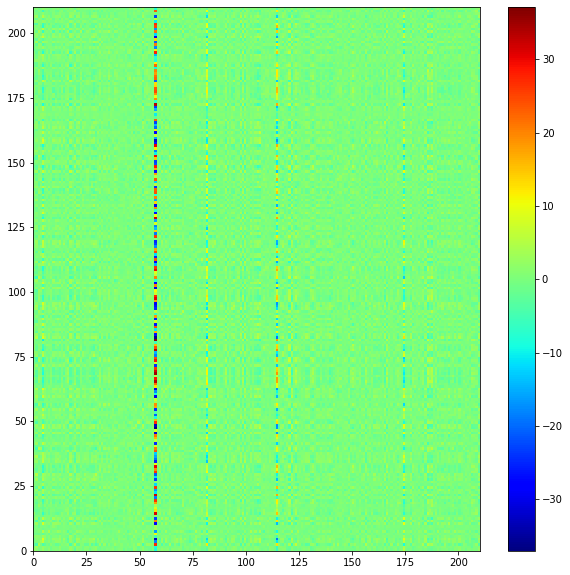

In [26]:
fig, ax0= plt.subplots(figsize=(10,10))

im = ax0.pcolormesh(W_reservoir, cmap="jet",)
fig.colorbar(im, ax=ax0)



# Entrainement de la sortie